# Smart Grid FDI – Positional Classification (BiLSTM)

This notebook trains a BiLSTM model to perform **positional false data injection (FDI) detection**:

- Label `0`  → no false data in the sequence
- Label `1..SEQ_LEN` → position of the false data point within the sequence

It expects the dataset generated by the positional version of `prepare_datasets.py`, e.g.:

```bash
python prepare_datasets.py
```

which should create an `.npz` file like:
`prepared_data/smartgrid_fdi_positional_seq5_diff0.npz`.

In [133]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# === Config ===
SEQ_LEN = 15  # must match SEQ_LEN in prepare_datasets.py
NPZ_PATH = "prepared_data/smartgrid_fdi_positional_seq15_diff0.npz"  # update if needed

data = np.load(NPZ_PATH)

X_train = data["X_train"]   # (N_train, seq_len, num_features)
y_train = data["y_train"]   # (N_train,) int labels in [0..SEQ_LEN]
X_val   = data["X_val"]
y_val   = data["y_val"]
X_test  = data["X_test"]
y_test  = data["y_test"]

num_features = X_train.shape[2]
num_classes  = SEQ_LEN + 1  # 0 = clean, 1..SEQ_LEN = attack position

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)
print("num_features:", num_features, "num_classes:", num_classes)

# Torch datasets / loaders
BATCH_SIZE = 64

train_ds = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).long(),
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(y_val).long(),
)
test_ds = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).long(),
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

Using device: cuda
Train: (2665, 15, 15) (2665,)
Val:   (333, 15, 15) (333,)
Test:  (334, 15, 15) (334,)
num_features: 15 num_classes: 16


In [134]:
class BiLSTMFDIPositional(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 64,
        num_layers: int = 1,
        bidirectional: bool = True,
        dropout: float = 0.25,
        num_classes: int = 6,
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        out_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(out_dim, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        out, _ = self.lstm(x)
        # Use last time-step output
        last_out = out[:, -1, :]  # (batch, out_dim)
        logits = self.fc(last_out)  # (batch, num_classes)
        return logits


def batch_accuracy_from_logits_multiclass(logits: torch.Tensor, labels: torch.Tensor) -> float:
    """Multiclass accuracy: argmax vs labels."""
    preds = logits.argmax(dim=1)
    return (preds == labels).float().mean().item()


def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_n = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE).long()

            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            n = y_batch.size(0)
            total_loss += loss.item() * n
            total_acc  += batch_accuracy_from_logits_multiclass(logits, y_batch) * n
            total_n += n

    return total_loss / total_n, total_acc / total_n


input_dim = num_features

model = BiLSTMFDIPositional(
    input_dim=input_dim,
    hidden_dim=32,
    num_layers=1,
    bidirectional=True,
    dropout=0.15,
    num_classes=num_classes,
).to(DEVICE)

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

BiLSTMFDIPositional(
  (lstm): LSTM(15, 32, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=16, bias=True)
)


In [135]:
NUM_EPOCHS = 500
LOSS_THRESHOLD = 0.1
best_val_loss = float("inf")

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    total_n = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE).long()

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        n = y_batch.size(0)
        running_loss += loss.item() * n
        running_acc  += batch_accuracy_from_logits_multiclass(logits, y_batch) * n
        total_n += n

    train_loss = running_loss / total_n
    train_acc  = running_acc / total_n
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(float(train_loss))
    val_losses.append(float(val_loss))
    train_accuracies.append(float(train_acc))
    val_accuracies.append(float(val_acc))

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_bilstm_fdi_positional.pt")
        print("  -> Saved new best model.")

    if val_loss < LOSS_THRESHOLD:
        print(f"  -> Validation loss {val_loss:.4f} < {LOSS_THRESHOLD}, early stopping at epoch {epoch}.")
        break

Epoch 01 | Train Loss: 2.3821, Acc: 0.4788 | Val Loss: 2.0480, Acc: 0.5015
  -> Saved new best model.
Epoch 02 | Train Loss: 2.0526, Acc: 0.4998 | Val Loss: 2.0443, Acc: 0.5015
  -> Saved new best model.
Epoch 03 | Train Loss: 2.0478, Acc: 0.4998 | Val Loss: 2.0440, Acc: 0.5015
  -> Saved new best model.
Epoch 04 | Train Loss: 2.0478, Acc: 0.4998 | Val Loss: 2.0428, Acc: 0.5015
  -> Saved new best model.
Epoch 05 | Train Loss: 2.0454, Acc: 0.4998 | Val Loss: 2.0431, Acc: 0.5015
Epoch 06 | Train Loss: 2.0446, Acc: 0.4998 | Val Loss: 2.0419, Acc: 0.5015
  -> Saved new best model.
Epoch 07 | Train Loss: 2.0426, Acc: 0.4998 | Val Loss: 2.0411, Acc: 0.5015
  -> Saved new best model.
Epoch 08 | Train Loss: 2.0407, Acc: 0.4998 | Val Loss: 2.0414, Acc: 0.5015
Epoch 09 | Train Loss: 2.0382, Acc: 0.4998 | Val Loss: 2.0444, Acc: 0.5015
Epoch 10 | Train Loss: 2.0352, Acc: 0.4998 | Val Loss: 2.0366, Acc: 0.5015
  -> Saved new best model.
Epoch 11 | Train Loss: 2.0310, Acc: 0.4998 | Val Loss: 2.0350

In [136]:
# Evaluate best checkpoint on test set
best_model = BiLSTMFDIPositional(
    input_dim=input_dim,
    hidden_dim=32,
    num_layers=1,
    bidirectional=True,
    dropout=0.15,
    num_classes=num_classes,
).to(DEVICE)

best_model.load_state_dict(torch.load("best_bilstm_fdi_positional.pt", map_location=DEVICE))

test_loss, test_acc = evaluate(best_model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0826, Test Accuracy: 0.9940


/tmp/ipykernel_8453/3287623977.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_bilstm_fdi_positional.pt", map_location=DEVIC

smartgrid_fdi_positional_seq15_diff0.5.npz


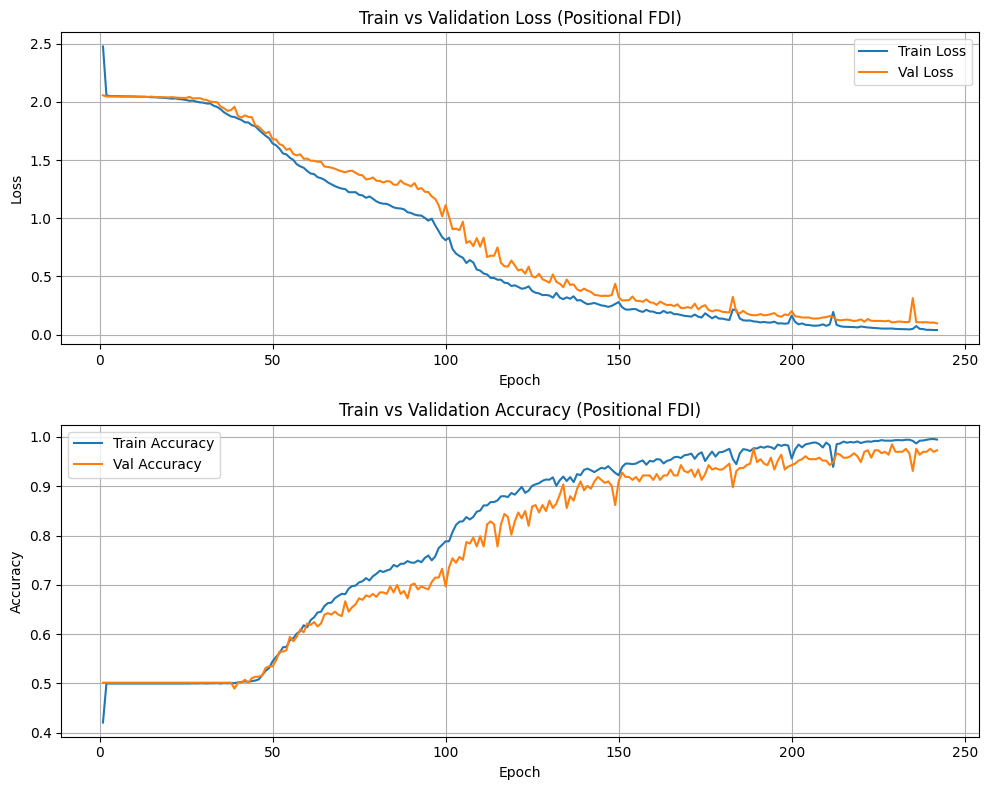

In [126]:
import os
# Plot training curves
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 8))

# Loss curves
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss (Positional FDI)")
plt.legend()
plt.grid(True)

# Accuracy curves
plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies,   label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy (Positional FDI)")
plt.legend()
plt.grid(True)

plt.tight_layout()

filename = os.path.basename(NPZ_PATH)

print(filename)
plt.savefig(f"images/{filename}.png")

plt.show()